In [1]:
import torch
import os 
import uuid
import pandas as pd
import torch.nn.functional as F
from scripts.utils import load_model
from tqdm import tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:

model_name = 'mistral7b'
tokenizer, model = load_model(f'{model_name}')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
import numpy as np
from scipy.stats import entropy
from numpy.linalg import norm
import numpy as np


def KL_divergence(P,Q):
    # print(P * np.log(P / Q))
    kl_values = P * np.log(P / Q)
    kl_values = kl_values[np.isfinite(kl_values)]  # remove entries where p or q is 0
    kl_div = np.sum(kl_values)
    return kl_div
    
def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return round(0.5 * (KL_divergence(_P, _M) + KL_divergence(_Q, _M)), 5)


# # Example usage:
# p = [0.4, 0.3, 0.2, 0.1]
# q = [0.2, 0.3, 0.4, 0.1]
# jsd_value = JSD(p, q)
# # jsd_value = jensen_shannon_divergence(p, q)
# print("Jensen-Shannon Divergence:", jsd_value)


In [11]:
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

def get_hstates_prediction(hstate, model):
    logits = model.lm_head(hstate.to('cuda'))
    probs = F.softmax(logits, dim=-1).cpu().detach()
    predicted_tokens = []
    for layer in probs:
        predicted_tokens.append(torch.tensor([torch.argmax(layer).item()]))
    assert(len(predicted_tokens) == probs.shape[0])
    predicted_tokens = torch.stack(predicted_tokens, dim = 0)
    return predicted_tokens, probs.cpu().detach().numpy()

# P(O) across layers
# P(M) across layers
# Preicted token at each layer
# JSD(V,M) for each layer
# sim(H(l), H{l-1)) forr layers 2, 32
# 0 - 32( 0 is embedding, 1 is layer 1, 32 is last layer))



def make_layer_df(df_dict,
                  layer_num,
                  prob_dist,
                  final_layer_prob,
                  predicted_tokens,
                 target_token):
    
    
    jsd_final_layer = JSD(final_layer_prob, prob_dist)
    
    # print(layer_num, jsd_final_layer)
    prob_dist = prob_dist.tolist()
    
    ### layer predicted token
    pred_prob = max(prob_dist)
    pred_token = predicted_tokens[layer_num].item()
            
    ### final generated token prob
    target_token_prob = prob_dist[target_token]
        
    top3_predicted_probs = sorted(prob_dist, reverse = True)[:3]
    top3_predicted_tokens = [prob_dist.index(each) for each in top3_predicted_probs]
    # print(layer_num, pred_prob, pred_token, target_token, target_token_prob)
    
    jsd_key = f'jsd_layer{layer_num}'
    df_dict[jsd_key] = [jsd_final_layer]

    pred_prob_layer_key = f'pred_prob_layer{layer_num}'
    df_dict[pred_prob_layer_key] = [pred_prob]
    
    pred_token_layer_key = f'pred_token_layer{layer_num}'
    df_dict[pred_token_layer_key] = [pred_token]

    target_prob_layer_key = f'target_prob_layer{layer_num}'
    df_dict[target_prob_layer_key] = [target_token_prob]

    top3_predicted_probs_key = f'top3_predicted_probs_layer{layer_num}'
    df_dict[top3_predicted_probs_key] = [top3_predicted_probs]

    top3_predicted_tokens_key = f'top3_predicted_tokens_layer{layer_num}'
    df_dict[top3_predicted_tokens_key] = [top3_predicted_tokens]
    return df_dict
                
def get_token_layer_info_dict(summ_token_hstates,
                              target_token,
                              factual_label,
                              model):
    
    predicted_tokens, probs = get_hstates_prediction(summ_token_hstates, model)
    
    rand_token_id = uuid.uuid4()
    df_dict = {
            'target_token': [],
            'label': []}
    
    df_dict['target_token'].append(f'{rand_token_id}_{target_token}')
    
    for layer_num in range(0, summ_token_hstates.shape[0]):
        if layer_num > 0:
            hidden_state_sim = cosine_similarity(summ_token_hstates[layer_num,:].unsqueeze(0), summ_token_hstates[layer_num- 1,:].unsqueeze(0))
            hidden_state_sim = hidden_state_sim[0][0]
            df_dict[f'prev_hidden_state_sim_layer{layer_num}'] = [hidden_state_sim]
            
    # print(summ_token_hstates.shape)
    final_layer_prob = probs[-1]
    # print(final_layer_prob.shape)
    for layer_num in range(0, predicted_tokens.shape[0]):
            prob_dist = probs[layer_num]
            
            
            df_dict = make_layer_df(df_dict,
                                    layer_num,
                                    prob_dist,
                                    final_layer_prob,
                                    predicted_tokens,
                                    target_token
                                    )
        
    df_dict['label'].append(factual_label)
    return pd.DataFrame(df_dict)
    
    
def get_summary_layer_info(example, model):
    # print(example)
    source_len = example['source_len']
    summary_len = example['summary_len']
    hidden_states = example['hidden_states']
    summary_tokens = example['all_tokens'][source_len: source_len + summary_len]
    summary_token_labels = example['summary_token_labels']
    if source_len.item() == 0:
        summary_hidden_states = hidden_states
    else:
        summary_hidden_states = hidden_states[:, source_len - 1: (source_len + summary_len) - 1, :]
    summary_hidden_states = summary_hidden_states.permute(1,0,2) ### we want to iterate of tokens not layers
    df_list = []
    
    for idx, summ_token_hstates in enumerate(summary_hidden_states):
        rand_token_id = uuid.uuid4()
        target_token = summary_tokens[idx]
        target_token_label = summary_token_labels[idx]
        
        
        
        
        ### hstate 0 is embedding 
        df_token_layer_info = get_token_layer_info_dict(summ_token_hstates, 
                                                        target_token = target_token,
                                                        factual_label = target_token_label,
                                                        model = model)
        
        df_list.append(df_token_layer_info)
        
    return pd.concat(df_list)

def make_prob_df(folder_path, model):
    files = os.listdir(folder_path)
    files = sorted(files)
    dfs_data = []
    all_docids = []
    for file_name in tqdm(files):
        docid = file_name.split('#')[-1].split('.pt')[0]
        if os.path.isfile(os.path.join(folder_path, file_name)):
            example = torch.load(os.path.join(folder_path, file_name))
            # return example
            df_example_dict = get_summary_layer_info(example, model)
            all_docids += [docid] * len(df_example_dict)
            dfs_data.append(df_example_dict)
            # break
    dfs_data = pd.concat(dfs_data)
    dfs_data['docid'] = all_docids
    return dfs_data


            

In [12]:
# df_data_document_context= make_prob_df('/scratch/ramprasad.sa/probing_summarization_factuality/internal_states/USB/XSUM/llama7b/document_context')
print(model_name)
df_data_document_context = make_prob_df(f'/scratch/ramprasad.sa/probing_summarization_factuality/internal_states/USB/XSUM/{model_name}/document_context',
                                       model)
# example.
# df_data_context= make_prob_df('/scratch/ramprasad.sa/probing_summarization_factuality/internal_states/USB/XSUM/falcon7b/context_only')




mistral7b


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 44/62 [30:00<12:16, 40.91s/it]


EOFError: Ran out of input

In [ ]:
df_data_document_context.to_csv(f'/scratch/ramprasad.sa/probing_summarization_factuality/metric_scores/layer_wise_uncertainty_{model_name}_xsum_document_context.csv')


,Unnamed: 0,target_token,label,prev_hidden_state_sim_layer1,prev_hidden_state_sim_layer2,prev_hidden_state_sim_layer3,prev_hidden_state_sim_layer4,prev_hidden_state_sim_layer5,prev_hidden_state_sim_layer6,prev_hidden_state_sim_layer7,...,target_prob_layer31,top3_predicted_probs_layer31,top3_predicted_tokens_layer31,jsd_layer32,pred_prob_layer32,pred_token_layer32,target_prob_layer32,top3_predicted_probs_layer32,top3_predicted_tokens_layer32,docid
0,0,6c787a77-2b4d-4c51-9522-c81c33caa64b_10823,0,0.502231,0.697886,0.883980,0.879269,0.897342,0.843042,0.882769,...,0.000170,"[0.00017794671293813735, 0.0001700913853710517...","[6735, 10823, 13]",0.0,0.296866,10823,0.296866,"[0.2968662679195404, 0.1760723739862442, 0.159...","[10823, 6735, 10598]",1701434231:mistral7b-ul2
1,0,e1a3216b-c2e9-494b-9aa6-b292fc58de32_346,0,0.640595,0.819120,0.855040,0.901019,0.911790,0.923048,0.887269,...,0.000219,"[0.00021923368331044912, 9.986708028009161e-05...","[346, 11394, 28724]",0.0,0.999998,346,0.999998,"[0.9999978542327881, 1.1988178130195593e-06, 4...","[346, 28724, 9880]",1701434231:mistral7b-ul2
2,0,6ae7e2c0-5f81-48c8-9f85-5c208f6f27ea_4871,0,0.365209,0.634182,0.769403,0.839417,0.898648,0.904766,0.915543,...,0.000451,"[0.00045103655429556966, 0.0001499827631050720...","[4871, 4768, 8010]",0.0,0.999990,4871,0.999990,"[0.9999904632568359, 3.867198302032193e-06, 3....","[4871, 2, 809]",1701434231:mistral7b-ul2
3,0,73af10f7-ae43-4df8-9b4d-8acd80c25672_6859,0,0.737261,0.536919,0.812472,0.859449,0.917738,0.905706,0.902446,...,0.000367,"[0.00036741080111823976, 0.0002478939713910222...","[6859, 9298, 2966]",0.0,0.957306,6859,0.957306,"[0.9573062062263489, 0.025002170354127884, 0.0...","[6859, 2966, 9298]",1701434231:mistral7b-ul2
4,0,3754be2e-c2cc-4bab-8783-a1a9a167d2da_3652,0,0.695037,0.832204,0.810061,0.866248,0.895663,0.868400,0.883450,...,0.000503,"[0.0005028111627325416, 0.000221054840949364, ...","[3652, 8417, 17904]",0.0,0.993595,3652,0.993595,"[0.9935947060585022, 0.0046989042311906815, 0....","[3652, 28725, 2]",1701434231:mistral7b-ul2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8572,0,2abebd58-40ec-45da-a163-26bcfadb6793_19046,0,0.651269,0.891362,0.863759,0.917792,0.908955,0.917567,0.881003,...,0.000385,"[0.00038469236460514367, 0.0001789521920727566...","[19046, 481, 9044]",0.0,0.999783,19046,0.999783,"[0.9997829794883728, 8.023810369195417e-05, 4....","[19046, 481, 2]",1701478712:mistral7b-ul2
8573,0,2239c2d1-c132-4b41-a39c-f3ea4e5c7b3d_297,0,0.673203,0.782844,0.846584,0.840643,0.906773,0.898784,0.862941,...,0.000255,"[0.000254612386925146, 0.00014977669343352318,...","[297, 28725, 568]",0.0,0.945326,297,0.945326,"[0.9453260898590088, 0.03830769285559654, 0.01...","[297, 28725, 28723]",1701478712:mistral7b-ul2
8574,0,b29533f3-cd29-4070-ad4d-c5de9cd03a07_456,0,0.628026,0.766359,0.788603,0.844659,0.903000,0.875541,0.878498,...,0.000434,"[0.0004337714344728738, 0.0002061405248241499,...","[456, 1178, 272]",0.0,0.975920,456,0.975920,"[0.9759204387664795, 0.0224151611328125, 0.001...","[456, 1178, 272]",1701478712:mistral7b-ul2
8575,0,8f124bc1-62c4-4ac6-81c6-4d05345795a2_2698,0,0.612289,0.820446,0.848606,0.908849,0.904515,0.899806,0.892966,...,0.000592,"[0.0005920096882618964, 0.0002178939466830343,...","[2698, 5020, 1834]",0.0,0.999237,2698,0.999237,"[0.9992374181747437, 0.0004242497670929879, 7....","[2698, 1834, 4166]",1701478712:mistral7b-ul2


In [15]:
# all_tokens = list(df_data_document_context['layer_token32'].values)
# for idx, tok in enumerate(all_tokens):
#     print(tokenizer.decode(tok))
def get_word_ids(df, 
                layer_name = 'layer_token32'):
    all_tokens = list(df[layer_name].values)

    words_idx = []
    word_id = 0
    for token_idx, token in enumerate(all_tokens):
        if token_idx != 0:
            prev_token = all_tokens[token_idx - 1]
            word = tokenizer.decode([prev_token, token])
            if len(word.split(' ')) > 1:
                word_id += 1
        words_idx.append(word_id)
    return words_idx

def make_word_boundaries(df):
    df_wordidx = []
    for unique_docid in list(set(df['docid'].values)):
        df_docid = df[df['docid'] == unique_docid]
        df_wordidx += get_word_ids(df_docid,
                                layer_name = 'layer_token32')
    assert(len(df_wordidx) == len(df))
    df['word_id'] = df_wordidx
    df['primary_key'] = [f"{row['docid']}_{row['word_id']}" for idx, row in df.iterrows()]
    return df


In [7]:
df_data_document_context = make_word_boundaries(df_data_document_context)
# df_data_context = make_word_boundaries(df_data_context)
# df_data_context.head()[:5]

/tmp/ipykernel_30150/4294371539.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['word_id'] = df_wordidx
/tmp/ipykernel_30150/4294371539.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['primary_key'] = [f"{row['docid']}_{row['word_id']}" for idx, row in df.iterrows()]


In [8]:
def get_sample(df):
    df_sample_nonfactual = df[df['label'] == 1]
    print('Factual/Nonfactual split', len(df[df['label'] == 0]), len(df_sample_nonfactual))
    df_sample_factual = df[df['label'] == 0].sample(len(df_sample_nonfactual))
    df_sample = pd.concat([df_sample_nonfactual, df_sample_factual
                                           ])
    return df_sample
    
df_sample_document_context = get_sample(df_data_document_context)
# df_sample_context = get_sample(df_data_context)
# df_sample_context = df_sample_context[df_sample_context['

Factual/Nonfactual split 6966 141


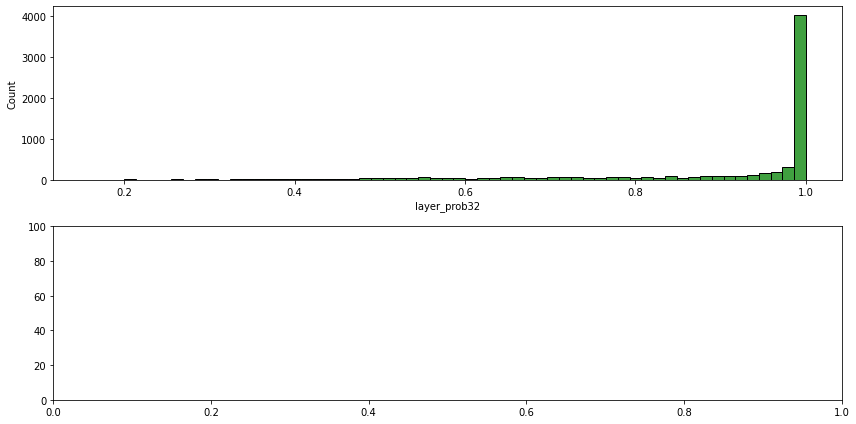

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

sns.histplot(df_data_document_context[df_data_document_context['label'] == 0]['layer_prob32'],  
             label='Factual Class',
            ax = axes[0],
            color='green')
# sns.histplot(df_sample_document_context[df_sample_document_context['label'] == 1]['layer_prob32'],  
#              label='Nonfactual Class',
#             ax = axes[1],
#             color='red')

# sns.distplot(df_sample_document_context[df_sample_document_context['label'] == 1]['layer_prob32'], 
#              kde=True, 
#              label='Factual Class',
#             ax = axes[1],
#             kde_kws={'bw_method': 0.2, 'common_norm': True})
plt.tight_layout()
plt.ylim(0, 100)
plt.xlim(0, 1)
# Show plot
plt.show()

In [10]:
for unique_docid in 

SyntaxError: invalid syntax (3033602285.py, line 1)

In [39]:
a = [    1, 26075,   264, 14060,   354,   272,  2296,  3248,   297,  6817,\
     28723,  1684,  6818,   272, 14060, 28725,   865,   938,  1871,   369,
          349,  2169,   297,   272,  3248,  4192, 28738,  2431, 28747,  6735,
        21351, 20067,  1342,   455,   392, 28725,  3890,   263, 16416,  5480,
         9227, 28725,   659, 26097,   264,  2966,   369, 10823,   346,  4871,
         6859,  3652, 28768,   339,  1337,  4403, 18811,   583,   583,   583,
          583,   583,   583,   583,  1411,   568,   345,  3260,  2966,   622,
         1316,  9850,   272, 10467,  1444,   905,   302,   272,  6735,  2191,
         1207,   304,  1395,   477,   272,  6120, 28733, 28706, 10230,  4605,
          862,  5480,  9227,  2240,   272, 16309,   568,   415,  3359, 28733,
         1536,  1526, 12264,   349,   477,   272,  9308, 27737, 13784,  1665,
          302,  2213,   508,   324,   568, 18811,   509,  4827, 28725,   693,
          659,   750,  7394,   272,  2966,   354,   264,   879, 28725,  5397,
          272,  3890,   263,   390,   396,   345,   583,   583,   583,   583,
          583,   583, 14780,   568,   345, 28737,   837,  1215, 17434,   395,
          272,  1069,  5480,  9227,   349,  5374,   559,  1411,   395,   579,
         1188, 24594,   304, 15276, 28723,   816, 28742,   584,  1149,  2739,
          356,   272,  2966,  1215,  3403, 28723,   315,  6253, 28742, 28707,
         4496,   356,   693,   622,  1156,   559,  3905,   862, 18811,   509,
         4827,  2240,   272, 16309,   568, 27186, 28725,  8577,   302,  6120,
        28733, 28706, 10230,   905, 20841,   272,  6735,  9245,   302,   351,
         2915,  1585, 28725, 13261,   282,   431,   304, 10540,   826, 20882,
         4813,   288,   312,   783,   278,   282, 10813,   297,   272, 11088,
          302, 18433,   533, 14650,  1444,   365, 11139, 26296,   304, 21731,
          297,   272,  6120, 28733, 28706, 10230,  1665,   302,  3348,   314,
          568,   415,  3890,   263,  2627,   630,   659,   750, 10728,   684,
          559, 21668,   304,  3282,  3687,   297, 13261,   282,   431,   304,
          345, 25327,   459,  9222,  4289,   438,  2125,   739,   456,   439,
          350,   381,   403,  3344,  1633, 28739,   568,   415,  3057,   302,
        21809,  8066,  8315,   369, 18811,   509,  4827, 28742, 28713,  2966,
          356,   559,   622,  1316,  3081,   272,  2423,  1096,   345,   423,
          905,   913,  1581,   562,   590,   460, 18161, 28723,   816,   506,
          272,  1348,  1455,   594,   739,   272,  2939,   349,  5290, 28739,
          568, 18811,   509,  4827, 28742, 28713, 13892, 17852,   969, 25694,
          283, 28725,   693,   312,   331,   283,  1572,  5480,  9227, 28742,
        28713,  1411,   304,  4677,   272,  6767, 28725,   622,  1863,   272,
         2966,   568,  1092,   622,   583,   583,   583,   583,   583,   583,
          583,   297,   272,  3890,   263, 28742, 28713,  1611,  1665,  2213,
          508,   324, 28725,   970,  3939,   270,   392, 14547,  1190,   506,
        24739,   264,  8743,   356, 10823,   346,  4871,  9922, 11030,   345,
        28737,  3317,   583,   583,   583,   583,   583,   583,   583,   378,
         1595,   411,   356,   586,  1411,  2838,   583,   583,   583,   583,
          583,   583,   583,   263,   862,  5480,  9227,   773,   568,  5558,
        28742, 28713,   306, 16982,  2966,  4779,   659, 13977,  7715,   356,
        18978,   477,   272,  2939, 28742, 28713,  1043, 28733, 20603,  1061,
         1006,  6120, 28733, 28706, 10230,  4605,   304,   272,  1664,  9922,
          369,   506,   750,  1269,   506,  9045,   356,   272,  3939,   270,
          392,  1488,  2821,  6094,   304,  5558, 28742, 28713,  5573, 28733,
         1126,  2821,  2090,  8280,   297,   272,  4424, 28723,   318,  4171,
        28755, 10713, 28747, 10823,   346,  4871,  6859,  3652, 28768,   339,
         1337,  4403, 18811,   509,  4827,  6400,   298,  1038,   264,  2966,
          356,  6735, 21351, 20067,  1342,   455,   392,  3890,   263, 16416,
         5480,  9227, 28742, 28713,  1411, 28725,   395,  5480,  9227,  4746,
        18063,   272,  2966,   390,   396, 16463,   298,  6735,  2525,   568,
        18811,   509,  4827, 28725,   693,   659,   750,  7394,   272,  2966,
          354,   264,   879, 28725,   349, 17434,   486,  5480,  9227, 28742,
        28713,  9802,   304, 15276, 28725,   304,   659,   459,  2783,  4496,
          356,   693,   622,  1156,   559,  3905,   568,   415,  2966,   349,
         3349,   298,  9850,   272, 10467,  1444,   905,   477,   272,  6735,
         2191,  1207,   304,  1395,   477,   272,  6120, 28733, 28706, 10230,
         4605, 28723]

In [11]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained('mistralai/Mistral-7B-Instruct-v0.1',
                                         cache_dir = '/scratch/ramprasad.sa/huggingface_models')

/home/ramprasad.sa/.conda/envs/probe/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [20]:
str1 = tokenizer.decode(a)

In [40]:
b = [1, 26075, 264, 14060, 354, 272, 2296, 3248, 297, 6817, 28723, 1684, 6818, 272, 14060, 28725, 865, 938, 1871, 369, 349, 2169, 297, 272, 3248, 4192, 28738, 2431, 28747, 6735, 21351, 20067, 1342, 455, 392, 28725, 3890, 263, 16416, 5480, 9227, 28725, 659, 26097, 264, 2966, 369, 10823, 346, 4871, 6859, 3652, 28768, 339, 1337, 4403, 18811, \
     583, 583, 583, 583, 583, 583, 583, 1411, 568, 345, 3260, 2966, 622, 1316, 9850, 272, 10467, 1444, 905, 302, 272, 6735, 2191,\
     1207, 304, 1395, 477, 272, 6120, 28733, 28706, 10230, 4605, 862, 5480, 9227, 2240, 272, 16309, 568, 415, 3359, 28733, 1536, 1526, 12264, 349, 477, 272, 9308, 27737, 13784, 1665, 302, 2213, 508, 324, 568, 18811, 509, 4827, 28725, 693, 659, \
     750, 7394, 272, 2966, 354, 264, 879, 28725, 5397, 272, 3890, 263, 390, 396, 345, 583, 583, 583, 583, 583, 583, 583, 28739, 568, 345, 28737, 837, 1215, 17434, 395, 272, 1069, 5480, 9227, 349, 5374, 559, 1411, 395, 579, 1188, 24594, 304, \
     15276, 28723, 816, 28742, 584, 1149, 2739, 356, 272, 2966, 1215, 3403, 28723, 315, 6253, 28742, 28707, 4496, 356, 693, 622, 1156, 559, 3905, 862, 18811, 509, 4827, 2240, 272, 16309, 568, 27186, 28725, 8577, 302, 6120, 28733, 28706, 10230, 905, \
     20841, 272, 6735, 9245, 302, 351, 2915, 1585, 28725, 13261, 282, 431, 304, 10540, 826, 20882, 4813, 288, 312, 783, 278, 282, 10813, 297, 272, 11088, 302, 18433, 533, 14650, 1444, 365, 11139, 26296, 304, 21731, 297, 272, 6120, 28733, 28706, \
     10230, 1665, 302, 3348, 314, 568, 415, 3890, 263, 2627, 630, 659, 750, 10728, 684, 559, 21668, 304, 3282, 3687, 297, 13261, 282, 431, 304, 345, 25327, 459, 9222, 4289, 438, 2125, 739, 456, 439, 350, 381, 403, 3344, 1633, 28739, 568, 415, \
     3057, 302, 21809, 8066, 8315, 369, 18811, 509, 4827, 28742, 28713, 2966, 356, 559, 622, 1316, 3081, 272, 2423, 1096, 345, 423, 905, 913, 1581, 562, 590, 460, 18161, 28723, 816, 506, 272, 1348, 1455, 594, 739, 272, 2939, 349, 5290, 28739, \
     568, 18811, 509, 4827, 28742, 28713, 13892, 17852, 969, 25694, 283, 28725, 693, 312, 331, 283, 1572, 5480, 9227, 28742, 28713, 1411, 304, 4677, 272, 6767, 28725, 622, 1863, 272, 2966, 568, 1092, 622, 583, 583, 583, 583, 583, 583, 583, 297, \
     272, 3890, 263, 28742, 28713, 1611, 1665, 2213, 508, 324, 28725, 970, 3939, 270, 392, 14547, 1190, 506, 24739, 264, 8743, 356, 10823, 346, 4871, 9922, 11030, 345, 28737, 3317, 583, 583, 583, 583, 583, 583, 583, 378, 1595, 411, 356,
     586, 1411, 2838, 583, 583, 583, 583, 583, 583, 583, 263, 862, 5480, 9227, 773, 568, 5558, 28742, 28713, 306, 16982, 2966, 4779, 659, 13977, 7715, 356, 18978, 477, 272, 2939, 28742, 28713, 1043, 28733, 20603, 1061, 1006, 6120, 28733, 28706, \
     10230, 4605, 304, 272, 1664, 9922, 369, 506, 750, 1269, 506, 9045, 356, 272, 3939, 270, 392, 1488, 2821, 6094, 304, 5558, 28742, 28713, 5573, 28733, 1126, 2821, 2090, 8280, 297, 272, 4424, 28723, 318, 4171, 28755, 10713, 28747, 10823, 346, \
     4871, 6859, 3652, 28768, 339, 1337, 4403, 18811, 509, 4827, 6400, 298, 1038, 264, 2966, 356, 6735, 21351, 20067, 1342, 455, 392, 3890, 263, 16416, 5480, 9227, 28742, 28713, 1411, 28725, 395, 5480, 9227, 4746, 18063, 272, 2966, 390, 396, \
     16463, 298, 6735, 2525, 568, 18811, 509, 4827, 28725, 693, 659, 750, 7394, 272, 2966, 354, 264, 879, 28725, 349, 17434, 486, 5480, 9227, 28742, 28713, 9802, 304, 15276, 28725, 304, 659, 459, 2783, 4496, 356, 693, 622, 1156, 559, 3905,568, \
     415, 2966, 349, 3349, 298, 9850, 272, 10467, 1444, 905, 477, 272, 6735, 2191, 1207, 304, 1395, 477, 272, 6120, 28733, 28706, 10230, 4605, 28723]

In [19]:
str2 = tokenizer.decode(b)

In [21]:
str1 == str2

True

In [22]:
a == b

False

In [23]:
str1

'<s> Generate a summary for the following document in brief. When creating the summary, only use information that is present in the document CONTENT: Indian Olympics bronze medallist, boxer MC Mary Kom, has welcomed a film that Bollywood director Sanjay Leela Bh _ _ _ _ _ _ _ life.. "This film will help bridge the gap between people of the Indian mainland and those from the north-eastern states," Mary Kom told the BBC.. The five-time world champion is from the remote northeast state of Manipur.. Bhansali, who has been planning the film for a year, described the boxer as an " _ _ _ _ _ _ _".. "I am very impressed with the way Mary Kom is leading her life with so much conviction and courage. We\'ll start working on the film very soon. I haven\'t decided on who will play her role," Bhansali told the BBC.. Recently, thousands of north-eastern people fled the Indian cities of Mumbai, Bangalore and Hyderabad fearing reprisal attacks in the wake of ethnic clashes between Bodo tribes and Musli

In [46]:
import torch
a = torch.tensor(a)
a.shape

/tmp/ipykernel_23128/3615579252.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(a)


torch.Size([602])

In [47]:
b = torch.tensor(b)
b.shape

/tmp/ipykernel_23128/3593657194.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(b)


torch.Size([603])

In [49]:
# for idx in range(0, 601):
#     if a[idx] != b[idx]:
#         print(idx)

a[141:]

tensor([  583, 14780,   568,   345, 28737,   837,  1215, 17434,   395,   272,
         1069,  5480,  9227,   349,  5374,   559,  1411,   395,   579,  1188,
        24594,   304, 15276, 28723,   816, 28742,   584,  1149,  2739,   356,
          272,  2966,  1215,  3403, 28723,   315,  6253, 28742, 28707,  4496,
          356,   693,   622,  1156,   559,  3905,   862, 18811,   509,  4827,
         2240,   272, 16309,   568, 27186, 28725,  8577,   302,  6120, 28733,
        28706, 10230,   905, 20841,   272,  6735,  9245,   302,   351,  2915,
         1585, 28725, 13261,   282,   431,   304, 10540,   826, 20882,  4813,
          288,   312,   783,   278,   282, 10813,   297,   272, 11088,   302,
        18433,   533, 14650,  1444,   365, 11139, 26296,   304, 21731,   297,
          272,  6120, 28733, 28706, 10230,  1665,   302,  3348,   314,   568,
          415,  3890,   263,  2627,   630,   659,   750, 10728,   684,   559,
        21668,   304,  3282,  3687,   297, 13261,   282,   431, 

In [50]:
b[141:]

tensor([  583,   583, 28739,   568,   345, 28737,   837,  1215, 17434,   395,
          272,  1069,  5480,  9227,   349,  5374,   559,  1411,   395,   579,
         1188, 24594,   304, 15276, 28723,   816, 28742,   584,  1149,  2739,
          356,   272,  2966,  1215,  3403, 28723,   315,  6253, 28742, 28707,
         4496,   356,   693,   622,  1156,   559,  3905,   862, 18811,   509,
         4827,  2240,   272, 16309,   568, 27186, 28725,  8577,   302,  6120,
        28733, 28706, 10230,   905, 20841,   272,  6735,  9245,   302,   351,
         2915,  1585, 28725, 13261,   282,   431,   304, 10540,   826, 20882,
         4813,   288,   312,   783,   278,   282, 10813,   297,   272, 11088,
          302, 18433,   533, 14650,  1444,   365, 11139, 26296,   304, 21731,
          297,   272,  6120, 28733, 28706, 10230,  1665,   302,  3348,   314,
          568,   415,  3890,   263,  2627,   630,   659,   750, 10728,   684,
          559, 21668,   304,  3282,  3687,   297, 13261,   282, 

In [71]:
tokenizer.decode([0,   0, 28739,   568,   345, 28737,   837,  1215, 17434,   395,
          272,  1069,  5480,])

'<unk><unk>".. "I am very impressed with the way Mary'

In [87]:
temp = tokenizer.decode([1, 0,   0, 28739,   568,   345, 28737,   837,  1215, 17434,   395,
          272,  1069,  5480])
temp.split('<s>')[-1]

'<unk><unk>".. "I am very impressed with the way Mary'

In [92]:
tokenizer.decode([1,26075,   264, 14060,   354,   272,  2296])

'<s> Generate a summary for the following'

In [70]:
temp

'_ _".. "I am very impressed with the way Mary'

In [82]:
tokenizer.decode([0, 28739])

'<unk>"'

In [81]:
tokenizer('"')

{'input_ids': [1, 345], 'attention_mask': [1, 1]}

In [60]:
tokenizer(tokenizer.unk_token).input_ids

[1, 0]

In [94]:
tokenizer('_ ')

{'input_ids': [1, 583, 28705], 'attention_mask': [1, 1, 1]}

In [96]:
tokenizer.add_special_tokens("[MASK]")

AttributeError: 'str' object has no attribute 'items'

In [97]:
tokenizer.add_tokens(['[MASK]'], special_tokens=True)

1

In [98]:
tokenizer('[MASK]')

{'input_ids': [1, 32000], 'attention_mask': [1, 1]}